In [1]:
import bambi as bmb
import pandas as pd
import arviz as az

In [2]:
crab = pd.read_csv("horseshoe_crab.csv")

In [3]:
model_crab_p = bmb.Model("satellite ~ width + C(color)", family="poisson", data=crab)
idata_crab_p = model_crab_p.fit(random_seed=123)
model_crab_p.predict(idata_crab_p, kind="response")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, width, C(color)]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [4]:
model_crab_hnb = bmb.Model("satellite ~ width + C(color)", family="hurdle_negativebinomial", data=crab)
idata_crab_hnb = model_crab_hnb.fit(random_seed=123)
model_crab_hnb.predict(idata_crab_hnb, kind="response")

/home/osvaldo/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/osvaldo/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/osvaldo/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op betainc does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/home/osvaldo/anaconda3/envs/pymc/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: O

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [5]:
az.to_netcdf(idata_crab_p, "idata_crab_p.nc")
az.to_netcdf(idata_crab_hnb, "idata_crab_hnb.nc")

'idata_crab_hnb.nc'

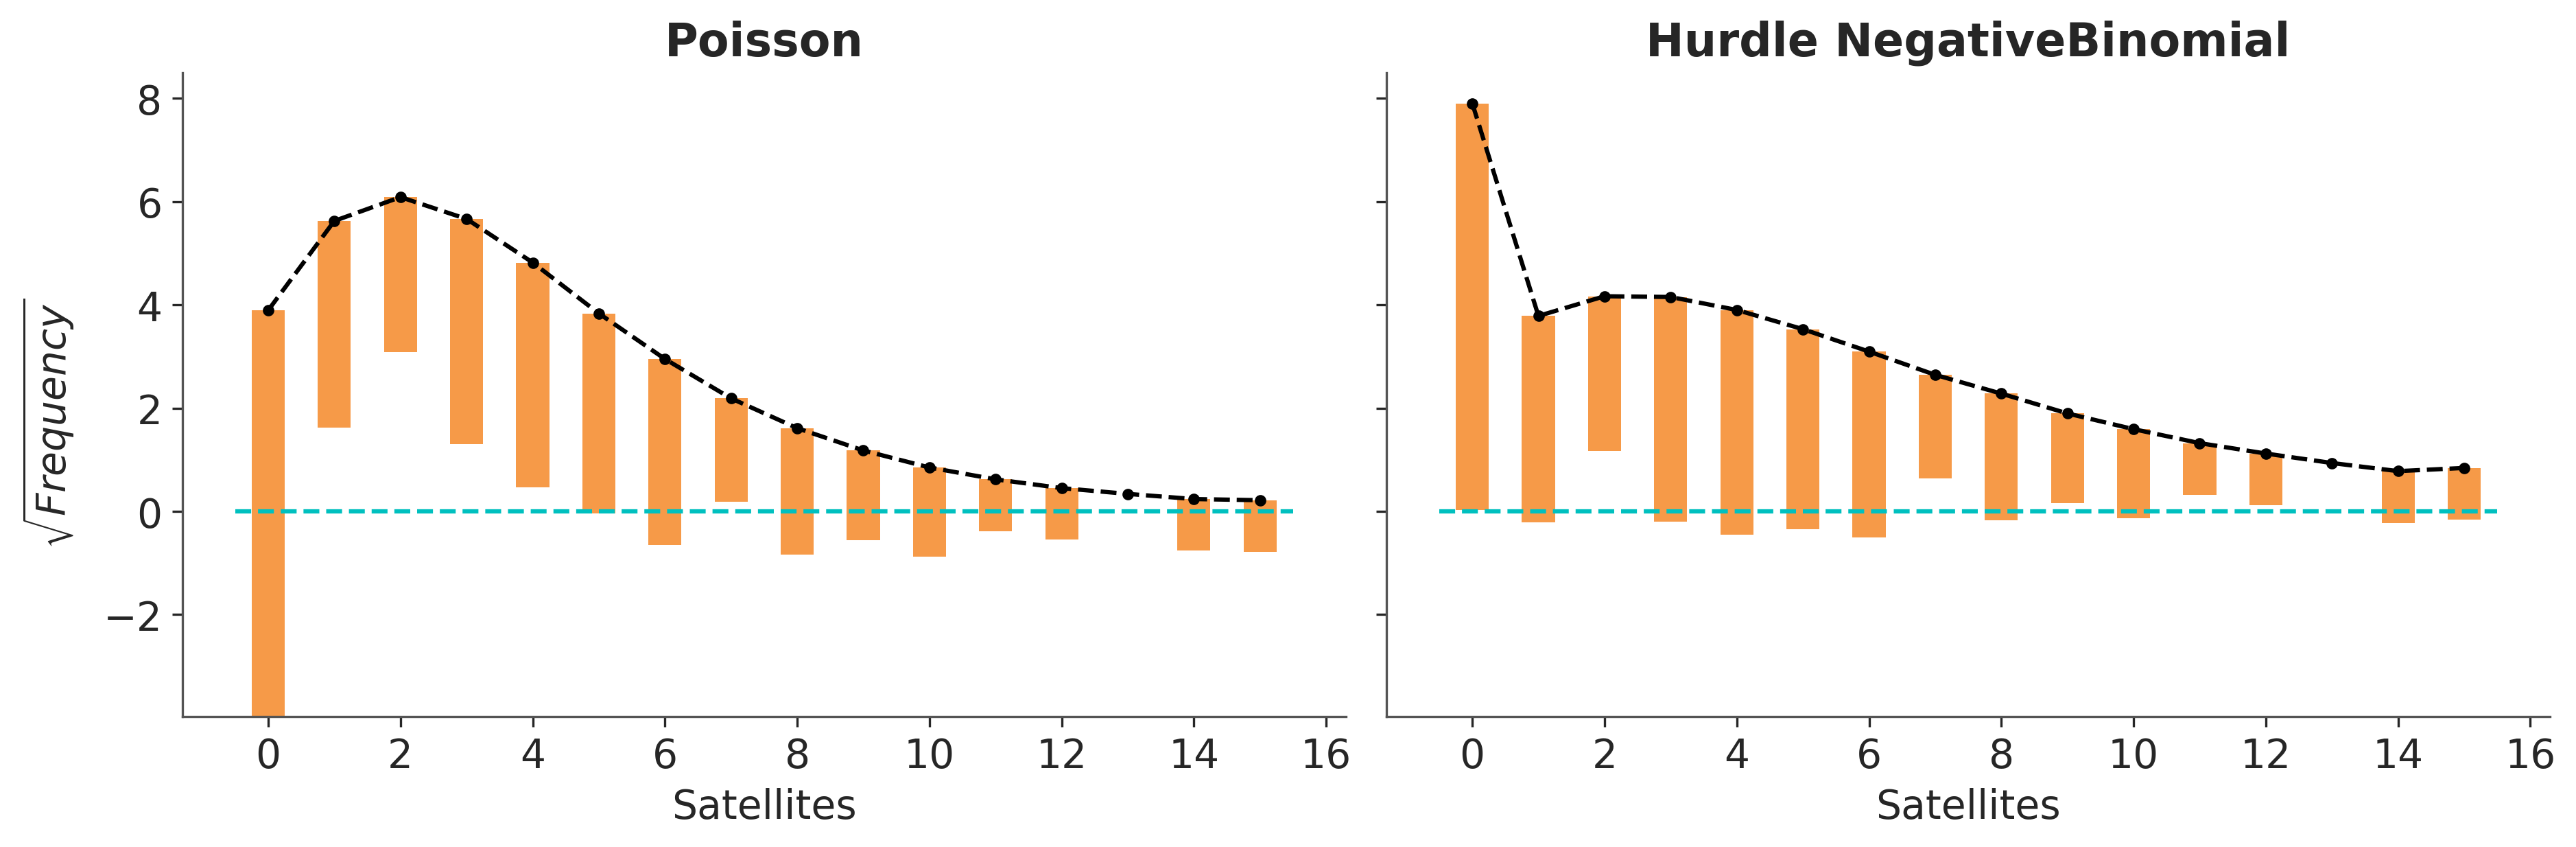

In [6]:
import matplotlib.pyplot as plt
import numpy as np
az.style.use("arviz-doc")

def rotogram(idata, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    ax.bar(bins[:-1], observed, 0.5, bottom=pred-observed, color="C2")
    ax.plot(bins[:-1], pred,  "k.--")
    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="C1")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{Frequency}$", va="center", rotation="vertical", fontsize=14);

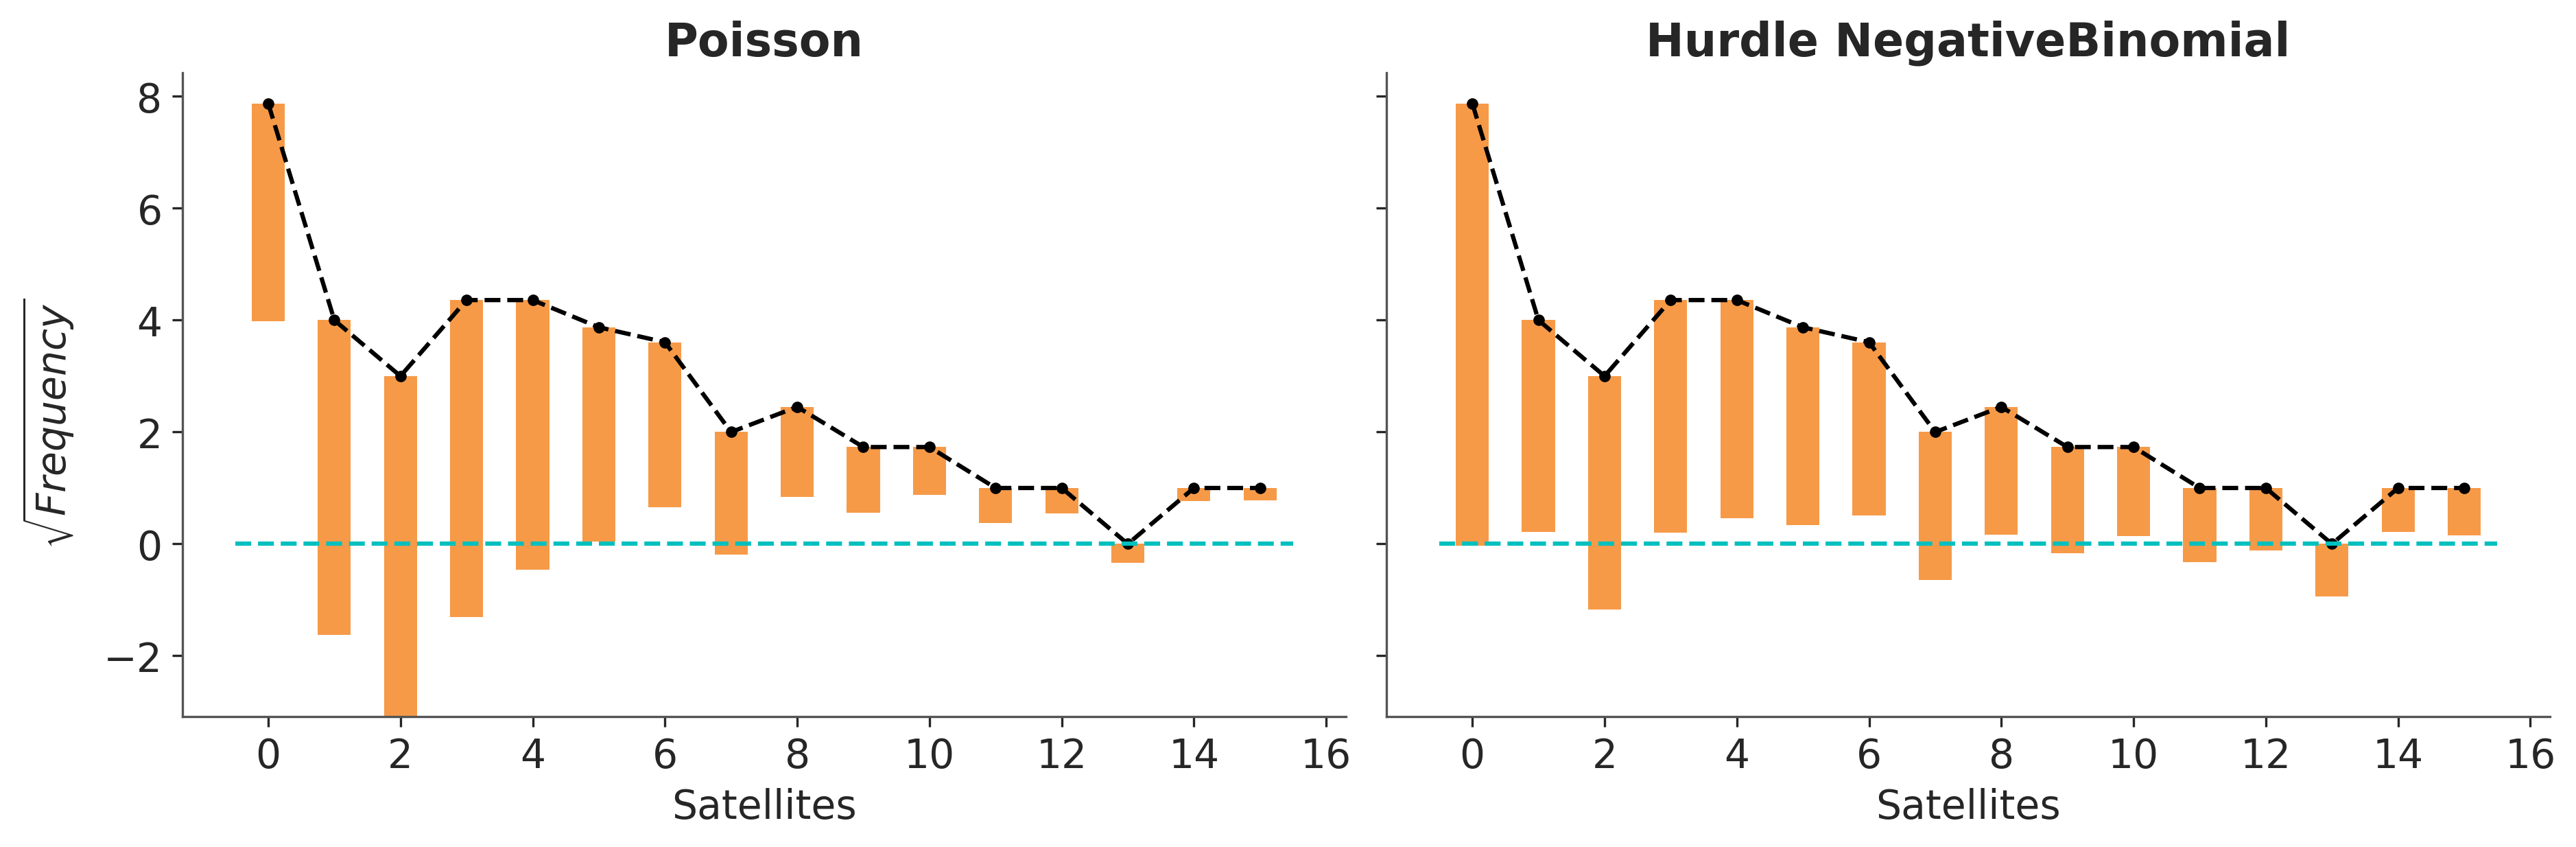

In [7]:
def rotogram(idata, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    ax.bar(bins[:-1], pred, 0.5, bottom=observed-pred, color="C2")
    ax.plot(bins[:-1], observed,  "k.--")
    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="C1")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{Frequency}$", va="center", rotation="vertical", fontsize=14);

In [8]:
def plot_ppc_discrete(idata, observed, bins, kind, ax):
    
    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    var_name = list(idata.observed_data.data_vars)[0]
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].values.T:
        counts = np.histogram(draw_values, bins=bins)[0]**0.5
        counts_list.append(counts)
        
    counts_arr = np.stack(counts_list)
    hdi_ = az.hdi(counts_arr)
    if kind == "hanging":
        add_discrete_bands(bins-0.5, observed-hdi_[:,0], observed-hdi_[:,1], ax=ax, color="C0", alpha=0.25)
    elif kind == "suspended":
        add_discrete_bands(bins-0.5, hdi_[:,0]-observed, hdi_[:,1]-observed, ax=ax, color="C0", alpha=0.25)

    return ax

/tmp/ipykernel_19302/3675049526.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/3675049526.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/3675049526.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/3675049526.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)


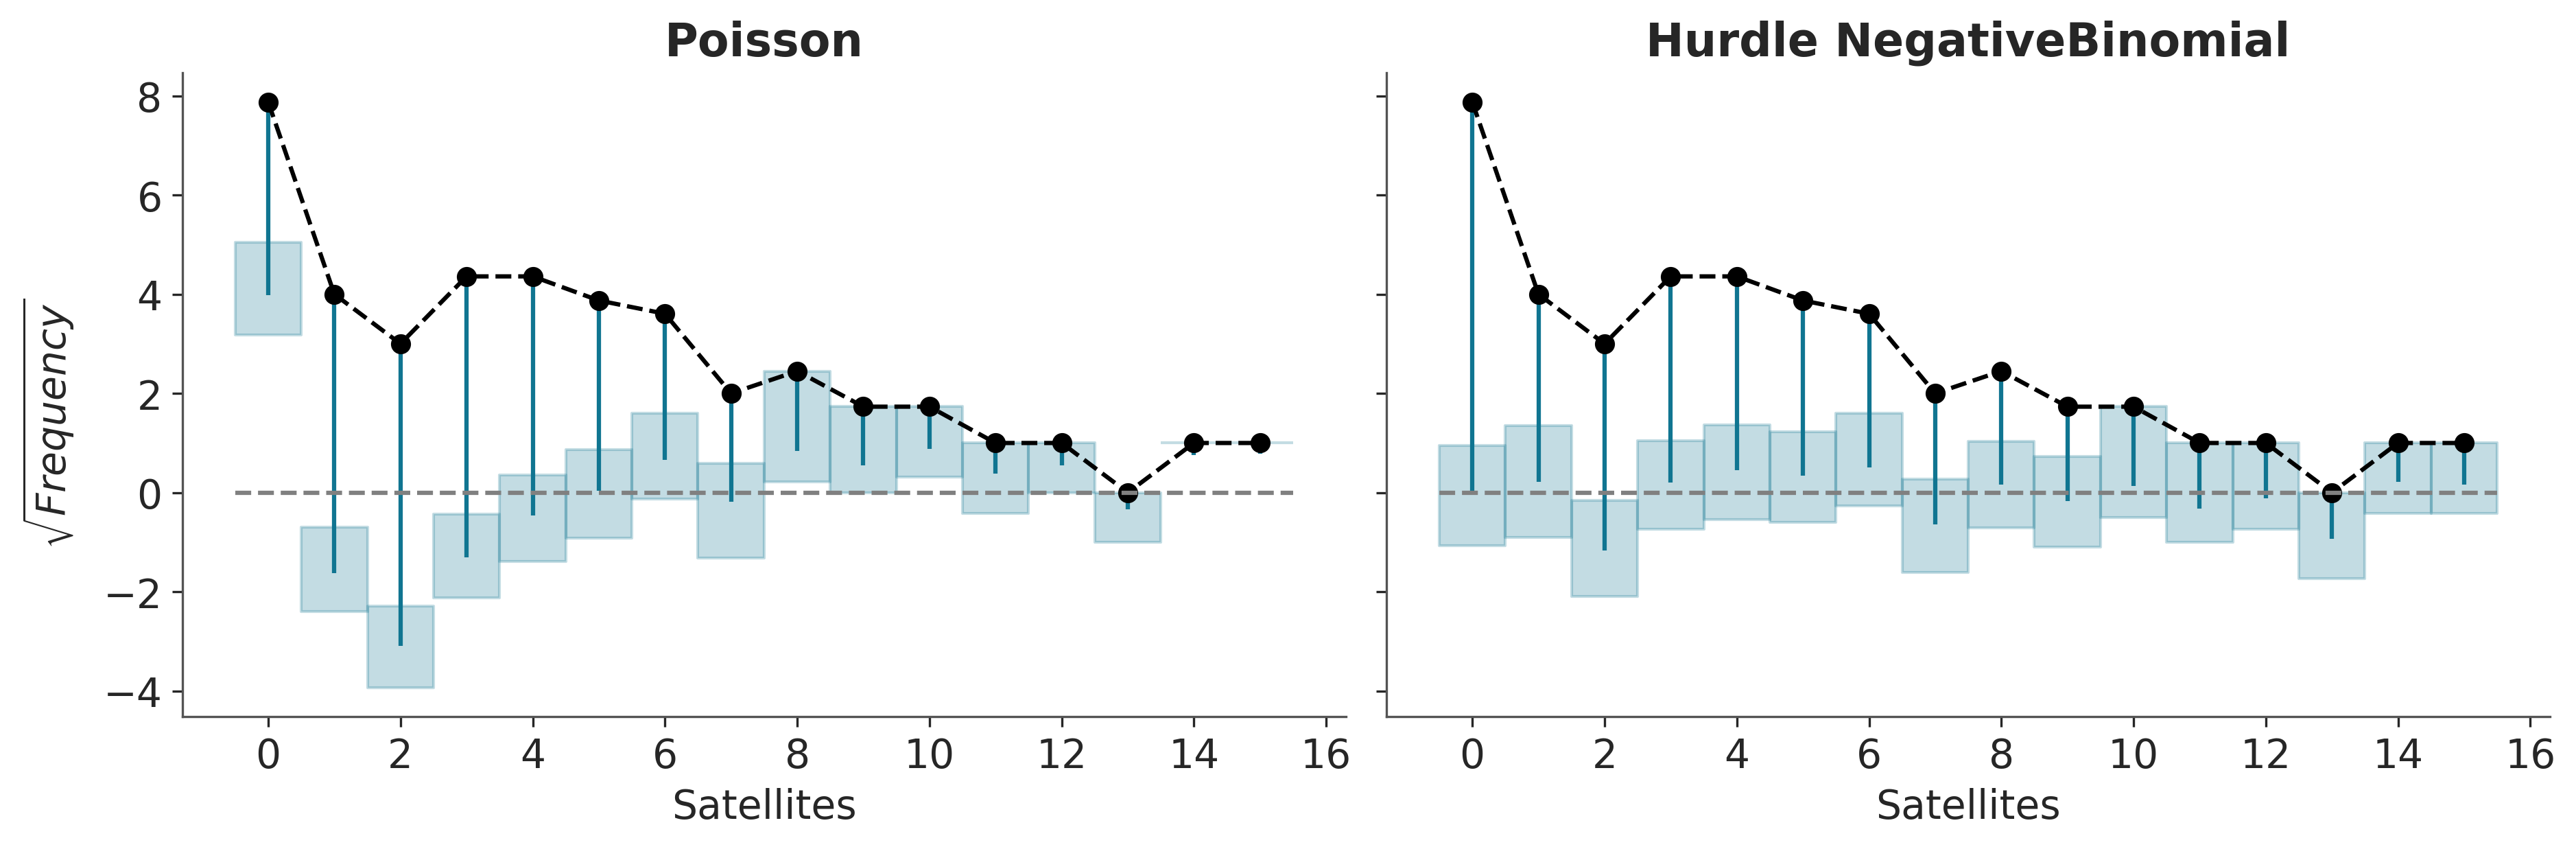

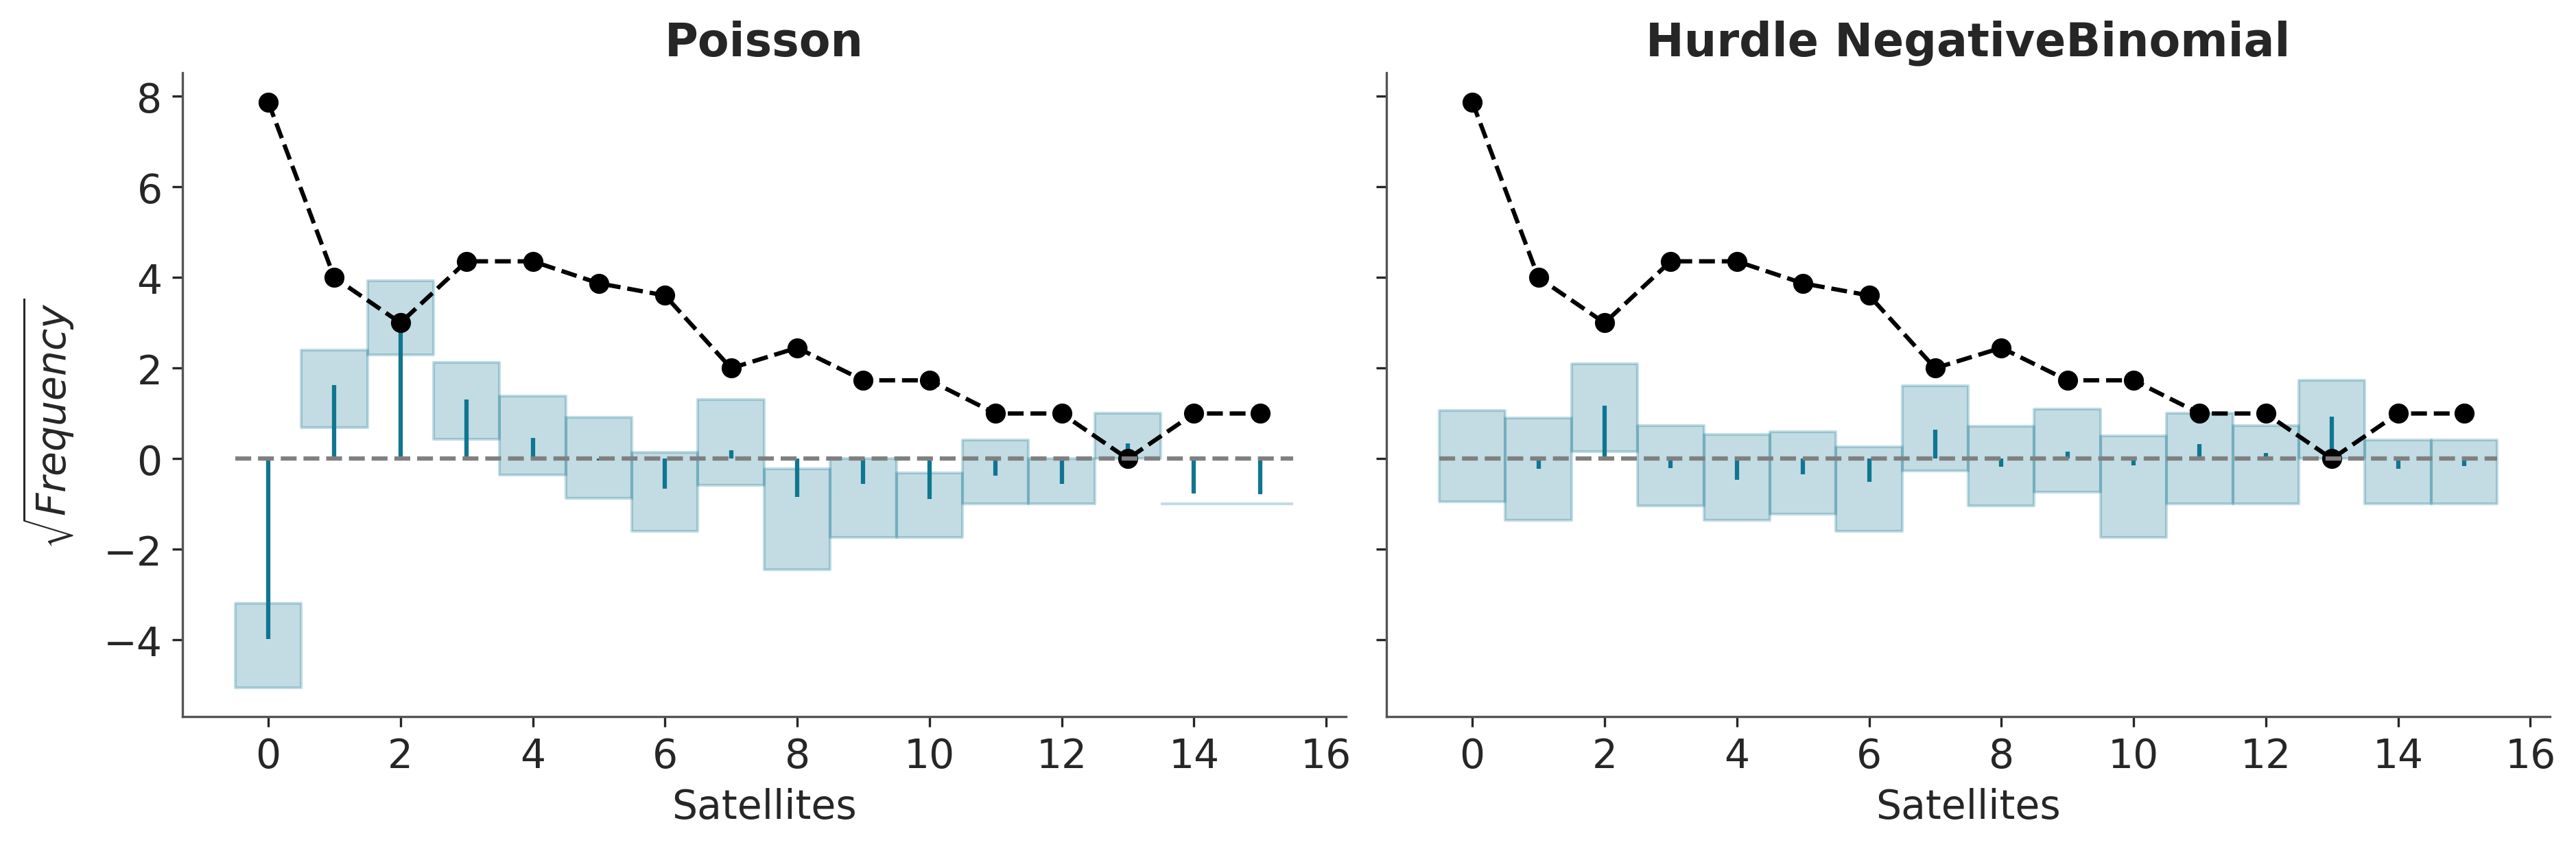

In [9]:
def rotogram(idata, kind, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    dims = idata.posterior_predictive.dims
    n_samples = dims["chain"] * dims["draw"]
    pred =  (np.histogram(idata.posterior_predictive["satellite"].values.ravel(),  bins=bins)[0] / n_samples)**0.5
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]**0.5

    if kind == "hanging":
        ax.vlines(bins[:-1], observed-pred, observed)
    elif kind == "suspended":
        ax.vlines(bins[:-1], 0, pred-observed)
    
    ax.plot(bins[:-1], observed,  "ko--")
    plot_ppc_discrete(idata, observed, bins, kind, ax)

    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="0.5")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "hanging", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{Frequency}$", va="center", rotation="vertical", fontsize=14);
plt.savefig("../../img/rootogram_hanging.png")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(), 
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "suspended", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "$\sqrt{Frequency}$", va="center", rotation="vertical", fontsize=14);
plt.savefig("../../img/rootogram_suspended.png")


In [17]:
def plot_ppc_discrete(idata, observed, bins, kind, ax):
    
    def add_discrete_bands(x, lower, upper, observed, kind, ax, **kwargs):
        for i, (l, u, obs) in enumerate(zip(lower, upper, observed)):
            xs = [x[i]+0.25, x[i+1]-0.25]
            if kind == "hanging":
                ax.fill_between(xs, [u, l], [u-obs, l-obs], **kwargs)
            else:
                ax.fill_between(xs, 0, [u-obs, l-obs], **kwargs)
            ax.plot(xs, [u, l], color="k")
            ax.plot(np.mean(xs), (u+l)/2, "k.", ls="--")

    var_name = list(idata.observed_data.data_vars)[0]
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].values.T:
        counts = np.histogram(draw_values, bins=bins)[0]
        counts_list.append(counts)
        
    counts_arr = np.stack(counts_list)
    hdi_ = az.hdi(counts_arr)
    add_discrete_bands(bins-0.5, hdi_[:,0], hdi_[:,1], observed, kind, ax=ax, color="C0", alpha=0.25)

    return ax

/tmp/ipykernel_19302/2087790704.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2087790704.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2087790704.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2087790704.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)


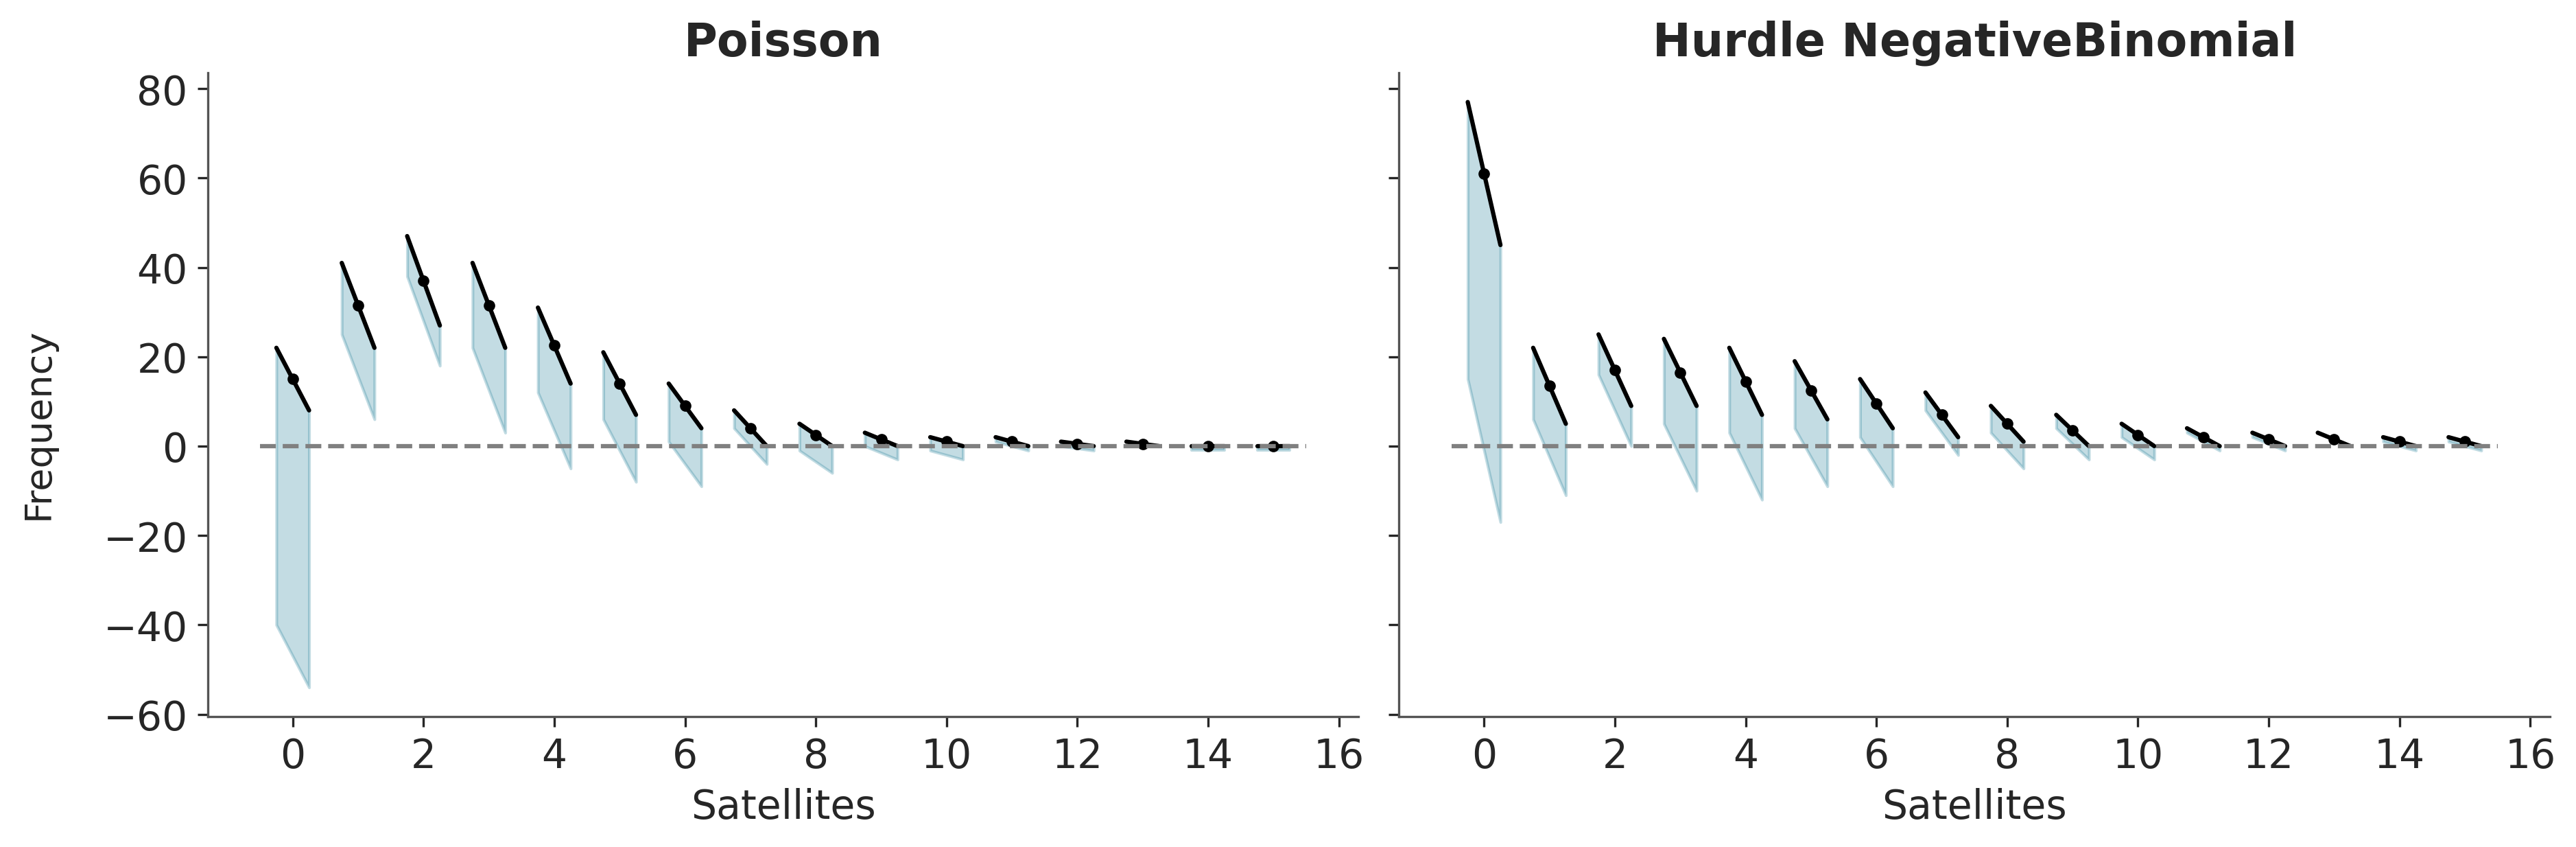

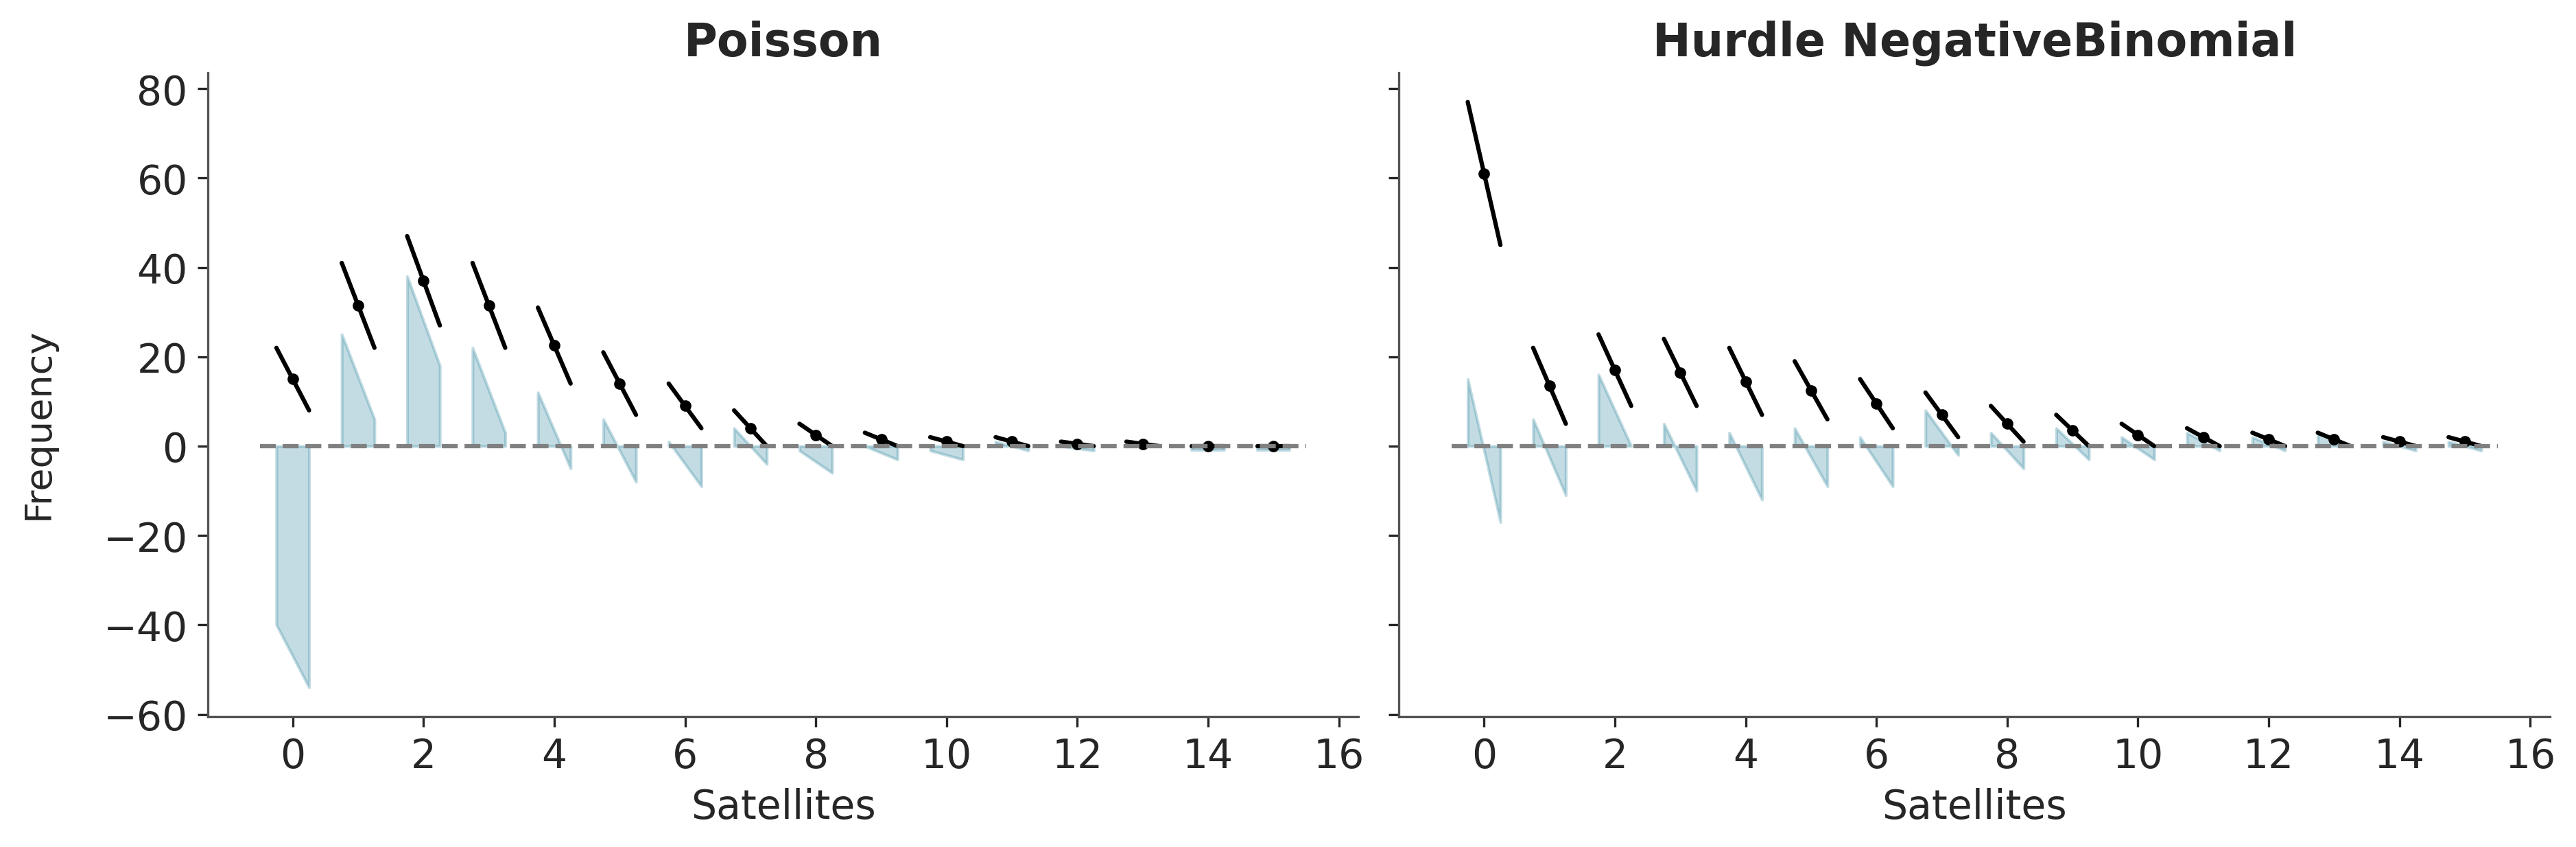

In [18]:
from matplotlib.scale import FuncScale

def rotogram(idata, kind, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]
    plot_ppc_discrete(idata, observed, bins, kind, ax)

    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="0.5")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(),
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "hanging", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
#fig.text(-0.03, 0.5, "Frequency ($\sqrt{\ }$-scale)", va="center", rotation="vertical", fontsize=13)
fig.text(-0.03, 0.5, "Frequency", va="center", rotation="vertical", fontsize=13)
plt.savefig("../../img/rootogram_hanging.png")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(),
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "suspended", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
#fig.text(-0.03, 0.5, "Frequency $(\sqrt{\ }$-scale)", va="center", rotation="vertical", fontsize=13)
fig.text(-0.03, 0.5, "Frequency", va="center", rotation="vertical", fontsize=13)
plt.savefig("../../img/rootogram_suspended.png")

In [12]:
def plot_ppc_discrete(idata, observed, bins, kind, ax):
    
    def add_discrete_bands(x, lower, upper, observed, kind, ax, **kwargs):
        for i, (l, u, obs) in enumerate(zip(lower, upper, observed)):
            xs = [x[i]+0.25, x[i+1]-0.25]
            if kind == "hanging":
                ax.fill_between(xs, [u, l], [u-obs, l-obs], **kwargs)
            else:
                ax.fill_between(xs, 0, [u-obs, l-obs], **kwargs)
            ax.plot(xs, [u, l], color="k")
            ax.plot(np.mean(xs), (u+l)/2, "k.", ls="--")

    var_name = list(idata.observed_data.data_vars)[0]
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].values.T:
        counts = np.histogram(draw_values, bins=bins)[0]#**0.5
        counts_list.append(counts)
        
    counts_arr = np.stack(counts_list)
    hdi_ = az.hdi(counts_arr)
    add_discrete_bands(bins-0.5, hdi_[:,0], hdi_[:,1], observed, kind, ax=ax, color="C0", alpha=0.25)

    return ax

/tmp/ipykernel_19302/2032949404.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2032949404.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2032949404.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)
/tmp/ipykernel_19302/2032949404.py:21: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(counts_arr)


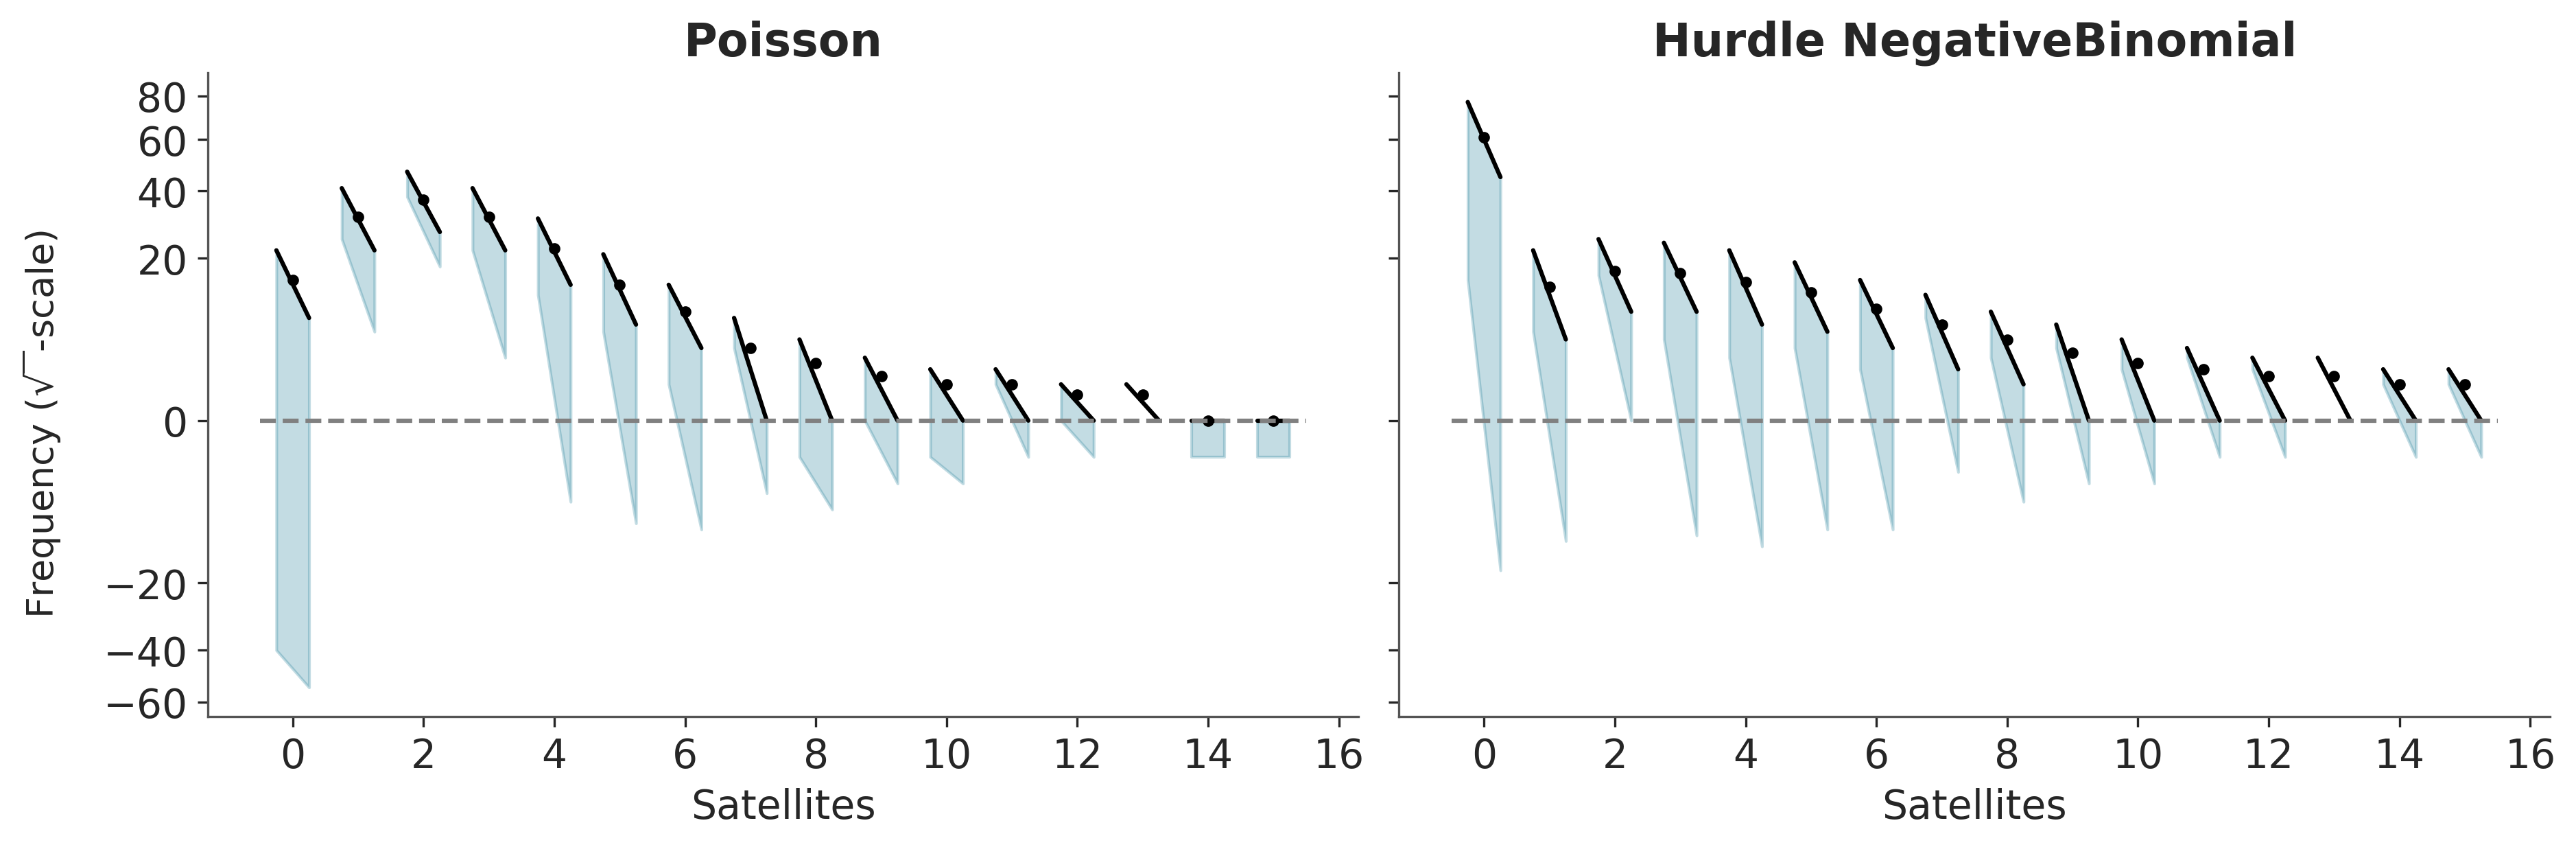

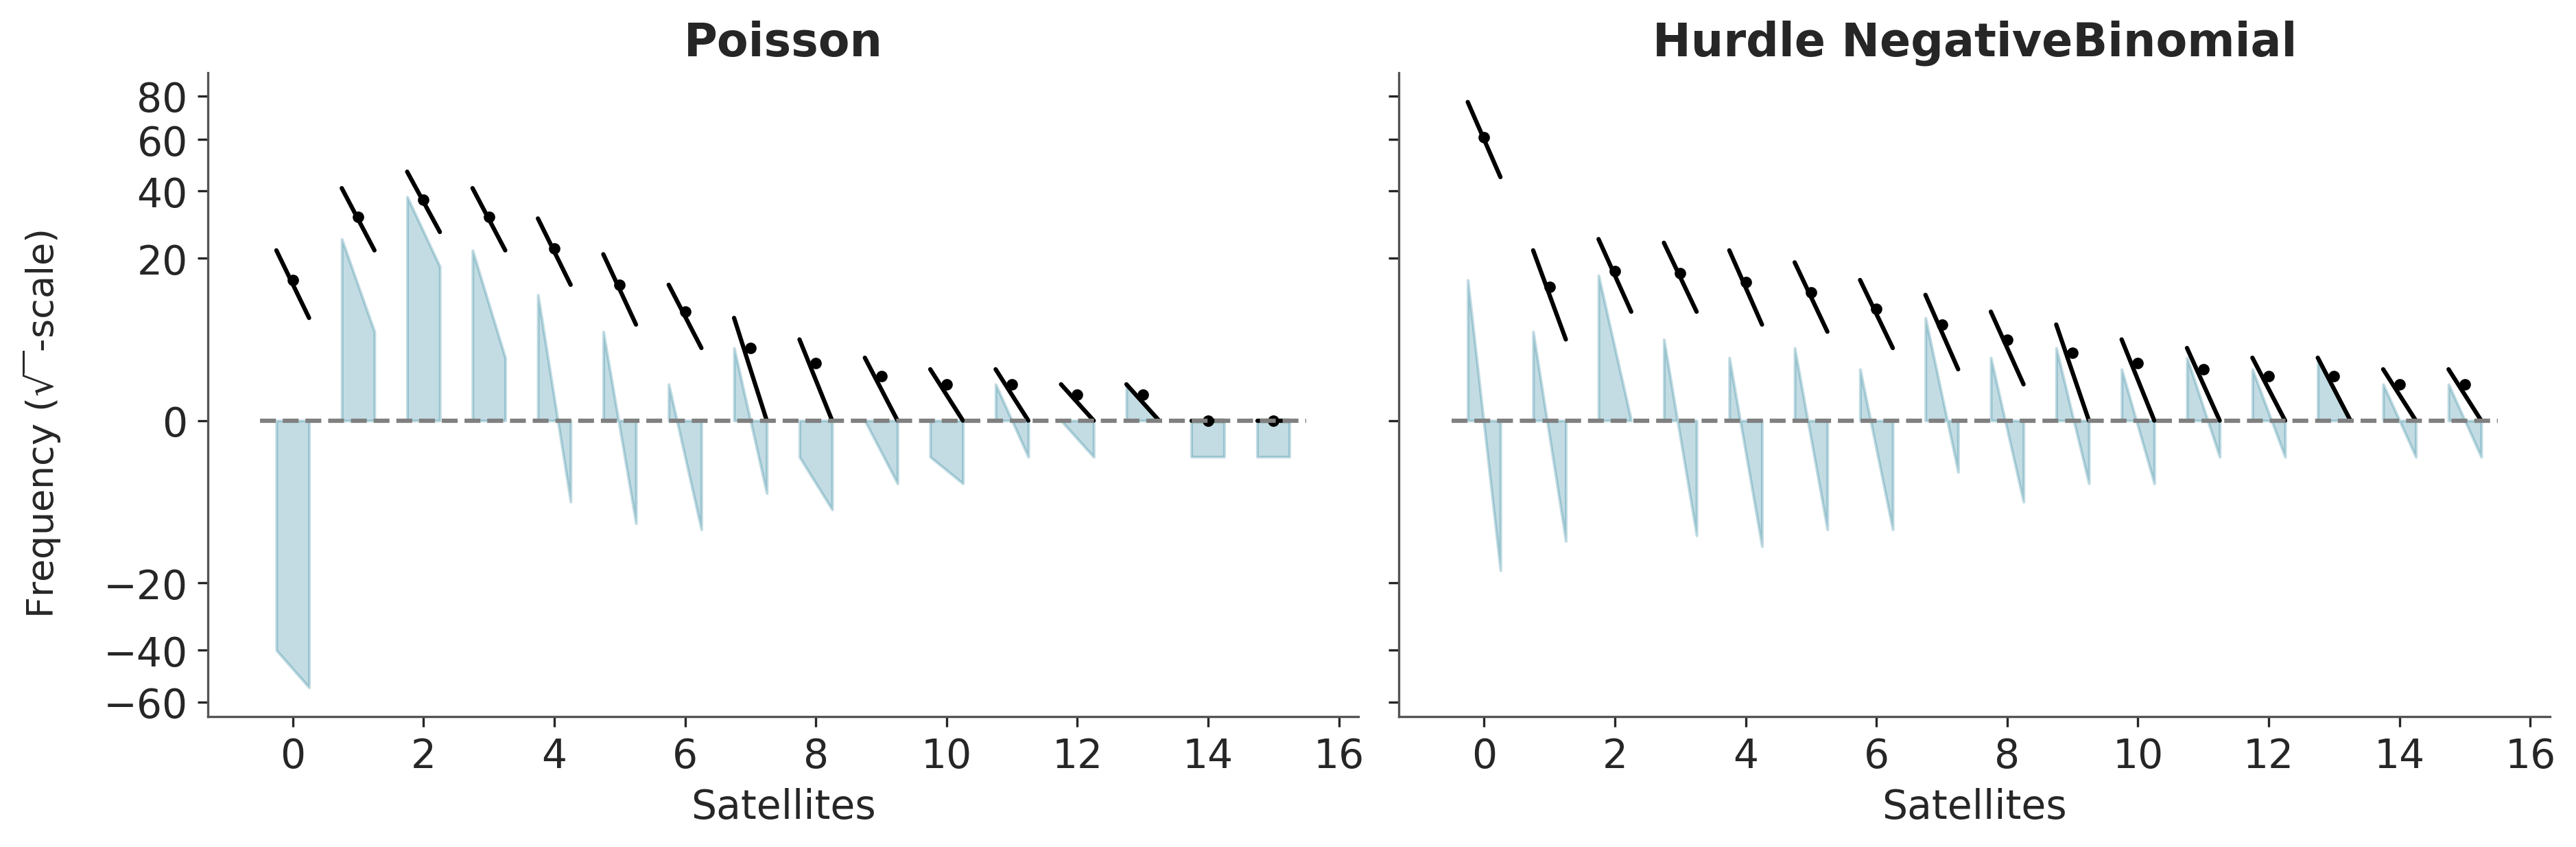

In [13]:
from matplotlib.scale import FuncScale

def rotogram(idata, kind, ax):
    max_ = 17
    bins = np.array(range(0, max_))
    observed = np.histogram(crab["satellite"].values, bins=bins)[0]#**0.5
    plot_ppc_discrete(idata, observed, bins, kind, ax)

    ax.hlines(0, -0.5, max_-1.5, linestyle="--", color="0.5")

    func = lambda x: np.sign(x)*np.sqrt(np.abs(x))
    inv_func = lambda x: np.sign(x)*(x**2)
    ax.set_yscale(FuncScale(ax, (func, inv_func)))


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(),
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "hanging", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "Frequency ($\sqrt{\ }$-scale)", va="center", rotation="vertical", fontsize=13)
#fig.text(-0.03, 0.5, "Frequency", va="center", rotation="vertical", fontsize=13)
plt.savefig("../../img/rootogram_hanging.png")


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
for ax, idata, model in zip(axes.ravel(),
                            [idata_crab_p, idata_crab_hnb],
                            ["Poisson", "Hurdle NegativeBinomial"]):
    rotogram(idata, "suspended", ax)
    ax.set_title(model)

axes[0].set_xlabel("Satellites")
axes[1].set_xlabel("Satellites")
fig.text(-0.03, 0.5, "Frequency $(\sqrt{\ }$-scale)", va="center", rotation="vertical", fontsize=13)
#fig.text(-0.03, 0.5, "Frequency", va="center", rotation="vertical", fontsize=13)
plt.savefig("../../img/rootogram_suspended.png")


In [14]:
idata.posterior_predictive["satellite"].values.ravel()

array([3, 5, 7, ..., 0, 7, 0])

In [15]:
np.sum(crab.satellite == 1)

16

In [16]:
(41**0.5-16**0.5), ((21**0.5)-(16**0.5))

(2.4031242374328485, 0.5825756949558398)